In [1]:
import os
import pickle
import numpy as np
import numpy.linalg as la
import PIL.Image
import PIL.ImageSequence
import dnnlib
import dnnlib.tflib as tflib
from IPython.display import display, clear_output
import moviepy
import moviepy.editor
import math
import glob
import csv
from functools import partial
import time
import collections
from itertools import product
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import pandas as pd
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.linear_model import LinearRegression, Lasso

import colorsys
import requests
import re
import copy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
##
# Load network snapshot
##

#input_sg_name = "2019-02-09-stylegan-danbooru2017-faces-network-snapshot-007841.pkl"

# From https://mega.nz/#!vOgj1QoD!GD3E37BroNnZaIR_nic2zVxBtKfAqlvbEC8uBK8-4co
#input_sg_name = "cache/2019-02-10-stylegan-asuka.pkl"
input_sg_name = "cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl"
#input_sg_name = "cache/karras2019stylegan-celebahq-1024x1024.pkl"
#input_sg_name = "cache/2019-02-18-stylegan-faces-network-02041-011095.pkl"

tflib.init_tf()

# Load pre-trained network.
with open(input_sg_name, 'rb') as f:
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.    
    _G, _D, Gs = pickle.load(f)
        
# Print network details.
Gs.print_layers()
_D.print_layers()

Instructions for updating:
Colocations handled automatically by placer.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 5

Downscale2D_1         -         (?, 3, 256, 256)     -               
FromRGB_lod2          256       (?, 64, 256, 256)    (1, 1, 3, 64)   
Grow_lod1             -         (?, 64, 256, 256)    -               
256x256/Conv0         36928     (?, 64, 256, 256)    (3, 3, 64, 64)  
256x256/Conv1_down    73856     (?, 128, 128, 128)   (3, 3, 64, 128) 
Downscale2D_2         -         (?, 3, 128, 128)     -               
FromRGB_lod3          512       (?, 128, 128, 128)   (1, 1, 3, 128)  
Grow_lod2             -         (?, 128, 128, 128)   -               
128x128/Conv0         147584    (?, 128, 128, 128)   (3, 3, 128, 128)
128x128/Conv1_down    295168    (?, 256, 64, 64)     (3, 3, 128, 256)
Downscale2D_3         -         (?, 3, 64, 64)       -               
FromRGB_lod4          1024      (?, 256, 64, 64)     (1, 1, 3, 256)  
Grow_lod3             -         (?, 256, 64, 64)     -               
64x64/Conv0           590080    (?, 256, 64, 64)     (3, 3, 256, 256)
64x64/Conv1_down    

In [4]:
num_layers = int(tf.get_default_graph().get_tensor_by_name('G_synthesis/dlatents_in:0').shape[1])
num_layers

18

In [5]:
out_shape = [int(i) for i in tf.get_default_graph().get_tensor_by_name('G_synthesis/images_out:0').shape[2:]]
out_shape

[1024, 1024]

In [6]:
##
# Build things on top for encoding
# Unfortunately this works only Kind Of Okay
# Based on https://github.com/Puzer/stylegan
##
def create_stub(name, batch_size):
    return tf.constant(0, dtype='float32', shape=(batch_size, 0))

dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
def create_variable_for_generator(name, batch_size):
    print("create_variable_for_generator called")  # added, so I know it was called. Todo: figure out why it's crashing
    truncation_psi_encode = 0.7
    layer_idx = np.arange(num_layers)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < 8, truncation_psi_encode * ones, ones)
    dlatent_variable = tf.get_variable(
        'learnable_dlatents', 
        shape=(1, num_layers, 512), 
        dtype='float32', 
        initializer=tf.initializers.zeros()
    )
    dlatent_variable_trunc = tflib.lerp(dlatent_avg, dlatent_variable, coefs)
    return dlatent_variable_trunc

# Generation-from-disentangled-latents part
initial_dlatents = np.zeros((1, num_layers, 512))
Gs.components.synthesis.run(
    initial_dlatents,
    randomize_noise = True, # Turns out this should not be off ever for trying to lean dlatents, who knew
    minibatch_size = 1,
    custom_inputs = [
        partial(create_variable_for_generator, batch_size=1),
        partial(create_stub, batch_size = 1)],
    structure = 'fixed', num_gpus=1
)

dlatent_variable = next(v for v in tf.global_variables() if 'learnable_dlatents' in v.name)
generator_output = tf.get_default_graph().get_tensor_by_name('G_synthesis_1/_Run/G_synthesis/images_out:0')
generated_image = tflib.convert_images_to_uint8(generator_output, nchw_to_nhwc=True, uint8_cast=False)
generated_image_uint8 = tf.saturate_cast(generated_image, tf.uint8)

# Loss part
vgg16 = VGG16(include_top=False, input_shape=(512, 512, 3))
perceptual_model = keras.Model(vgg16.input, vgg16.layers[9].output)
generated_img_features = perceptual_model(preprocess_input(generated_image, mode="tf"))
ref_img = tf.get_variable(
    'ref_img', 
    shape = generated_image.shape,
    dtype = 'float32', 
    initializer = tf.zeros_initializer()
)
ref_img_features = tf.get_variable(
    'ref_img_features', 
    shape = generated_img_features.shape,
    dtype = 'float32', 
    initializer = tf.zeros_initializer()
)
tf.get_default_session().run([ref_img.initializer, ref_img_features.initializer])
basic_loss = tf.losses.mean_squared_error(ref_img, generated_image)
perceptual_loss = tf.losses.mean_squared_error(ref_img_features, generated_img_features)

d_input_shape = (1, 3, out_shape[0], out_shape[1])
_D.run(np.zeros(d_input_shape), None, custom_inputs = [
    lambda x: generator_output,
    partial(create_stub, batch_size = 1),
])
discriminator_output = tf.get_default_graph().get_tensor_by_name('D/_Run/D/scores_out:0')

# Attempt at making encoding better: Bias towards mean ("truncation loss", essentially)
dlatent_avg_full = dlatent_avg.reshape(-1, 512).repeat(num_layers, axis=0).reshape(-1, num_layers, 512)
input_loss = tf.losses.mean_squared_error(dlatent_variable, dlatent_avg_full)
combined_loss = input_loss + perceptual_loss
# We have a discriminator network, why not use it?
discriminator_loss = tf.nn.softplus(-discriminator_output)

create_variable_for_generator called
Instructions for updating:
Use tf.cast instead.


In [17]:
## todo: this is only for testing, not real code

# Tune image in the direction of being considered more likely by the discriminator
def tune_with_discriminator(dlatents, iterations=32, learning_rate=1.0, show_progress=False, opt_class=tf.train.GradientDescentOptimizer):
    
    # Gradient descent
    # only optimizer without any variables works here for some reason, work it out somehow
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.AdadeltaOptimizer(learning_rate = learning_rate)
    optimizer = opt_class(learning_rate=learning_rate)

    # Get session
    sess = tf.get_default_session()
    sess.run(tf.global_variables_initializer())
    # from https://stackoverflow.com/questions/35164529/in-tensorflow-is-there-any-way-to-just-initialize-uninitialised-variables
    #vars_to_init = list(tf.get_variable(name) for name in sess.run(tf.report_uninitialized_variables(tf.global_variables())))
    init=tf.local_variables_initializer()
    sess.run(init)
    #names_to_init = sess.run(tf.report_uninitialized_variables(tf.local_variables()))
    #print(names_to_init)
    #vars_to_init = list(tf.get_variable(name) for name in names_to_init)
    #if len(vars_to_init) > 0:
    #    sess.run(tf.initialize_variables(vars_to_init))

    # Assign initial dlatents
    sess.run(tf.assign(dlatent_variable, dlatents))
    
    min_op = optimizer.minimize(discriminator_loss, var_list=[[dlatent_variable]])
    losses = []
    for i in range(iterations):
        _, loss = sess.run([min_op, discriminator_loss])
        losses.append(loss[0, 0])
        if i % 100 == 0:
            print("i: {}, l: {}".format(i, loss))
        if i % 100 == 0 and show_progress:
            dlatents_val = tf.get_default_session().run(dlatent_variable)[0]
            display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_val, truncation_psi = display_psi_2), 'RGB').resize((256, 256)))
    
    return sess.run(dlatent_variable)[0], losses

mod_latents = np.load("mod_latents.npy")
dlatents_gen = Gs.components.mapping.run(mod_latents, None)
tune_with_discriminator(dlatents_gen, iterations=1, learning_rate=0.1, show_progress=False, opt_class=partial(tf.train.MomentumOptimizer, momentum=0.9))


FailedPreconditionError: Attempting to use uninitialized value learnable_dlatents/Momentum_1
	 [[node Momentum_1/update_learnable_dlatents/ApplyMomentum (defined at <ipython-input-17-084ff2165775>:27) ]]

Caused by op 'Momentum_1/update_learnable_dlatents/ApplyMomentum', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-084ff2165775>", line 42, in <module>
    tune_with_discriminator(dlatents_gen, iterations=1, learning_rate=0.1, show_progress=False, opt_class=partial(tf.train.MomentumOptimizer, momentum=0.9))
  File "<ipython-input-17-084ff2165775>", line 27, in tune_with_discriminator
    min_op = optimizer.minimize(discriminator_loss, var_list=[[dlatent_variable]])
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 413, in minimize
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 612, in apply_gradients
    update_ops.append(processor.update_op(self, grad))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 119, in update_op
    update_op = optimizer._apply_dense(g, self._v)  # pylint: disable=protected-access
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\momentum.py", line 103, in _apply_dense
    use_nesterov=self._use_nesterov).op
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\gen_training_ops.py", line 713, in apply_momentum
    use_nesterov=use_nesterov, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value learnable_dlatents/Momentum_1
	 [[node Momentum_1/update_learnable_dlatents/ApplyMomentum (defined at <ipython-input-17-084ff2165775>:27) ]]


In [20]:
# Gradient descend in latent space to something that is similar to the input image
def encode_image(image, iterations = 1024, learning_rate = 0.1, reset_dlatents = True, custom_initial_dlatents = None):
    # Get session
    sess = tf.get_default_session()
    
    # Gradient descent initial state
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    optimizer = tf.train.AdadeltaOptimizer(learning_rate = learning_rate)
    min_op = optimizer.minimize(perceptual_loss, var_list=[[dlatent_variable]])
    if reset_dlatents == True:
        if not custom_initial_dlatents is None:
            sess.run(tf.assign(dlatent_variable, custom_initial_dlatents.reshape(-1, num_layers, 512)))
        else:
            sess.run(tf.assign(dlatent_variable, initial_dlatents))
    
    # Generate and set reference image features
    ref_image_data = np.array(list(map(lambda x: (x.astype("float32")), [image])))
    image_features = perceptual_model.predict_on_batch(preprocess_input(ref_image_data, mode="tf"))  
    sess.run(tf.assign(ref_img_features, image_features))
    
    # Run
    for i in range(iterations):
        _, loss = sess.run([min_op, perceptual_loss])
        if i % 100 == 0:
            print("i: {}, l: {}".format(i, loss))
    
    # Generate image that actually goes with these dlatents for quick testing
    dlatents = sess.run(dlatent_variable)[0]
    generated_image = generate_images_from_dlatents(dlatents)
    
    return dlatents, generated_image

# Same as above but start with given dlatents and use plain MSE loss instead of vgg16
def finetune_image(dlatents, image, iterations = 32, learning_rate = 0.0001):
    # Get session and assign initial dlatents
    sess = tf.get_default_session()
    sess.run(tf.assign(dlatent_variable, dlatents))
    
    # Set reference image
    ref_image_data = np.array(list(map(lambda x: (x.astype("float64")), [image])))
    sess.run(tf.assign(ref_img, ref_image_data))    
    
    # Gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    min_op = optimizer.minimize(basic_loss, var_list=[[dlatent_variable]])
    
    for i in range(iterations):
        _, loss = sess.run([min_op, basic_loss])
        if i % 100 == 0:
            print("i: {}, l: {}".format(i, loss))

    # Generate image that actually goes with these latents for quick testing
    dlatents = sess.run(dlatent_variable)[0]
    generated_image = generate_images_from_dlatents(dlatents)
    
    return dlatents, generated_image

# Tune image in the direction of being considered more likely by the discriminator
def tune_with_discriminator(dlatents, iterations=32, learning_rate=1.0, show_progress=False, opt_class=tf.train.GradientDescentOptimizer):
    # Get session
    sess = tf.get_default_session()
    
    # Gradient descent
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.AdadeltaOptimizer(learning_rate = learning_rate)
    optimizer = opt_class(learning_rate=learning_rate)
    # from https://stackoverflow.com/questions/35164529/in-tensorflow-is-there-any-way-to-just-initialize-uninitialised-variables
    #vars_to_init = list(tf.get_variable(name) for name in sess.run(tf.report_uninitialized_variables(tf.global_variables())))
    vars_to_init = list(tf.get_variable(name) for name in sess.run(tf.report_uninitialized_variables(tf.local_variables())))
    if len(vars_to_init) > 0:
        sess.run(tf.initialize_variables(vars_to_init))

    # Assign initial dlatents
    sess.run(tf.assign(dlatent_variable, dlatents))
    
    min_op = optimizer.minimize(discriminator_loss, var_list=[[dlatent_variable]])
    losses = []
    for i in range(iterations):
        _, loss = sess.run([min_op, discriminator_loss])
        losses.append(loss[0, 0])
        if i % 100 == 0:
            print("i: {}, l: {}".format(i, loss))
        if i % 100 == 0 and show_progress:
            dlatents_val = tf.get_default_session().run(dlatent_variable)[0]
            display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_val, truncation_psi = display_psi_2), 'RGB').resize((256, 256)))
    
    return sess.run(dlatent_variable)[0], losses

# We have to do truncation ourselves, since we're not using the combined network
def truncate(dlatents, truncation_psi, maxlayer = 8):
    dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
    layer_idx = np.arange(num_layers)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < maxlayer, truncation_psi * ones, ones)
    return tf.get_default_session().run(tflib.lerp(dlatent_avg, dlatents, coefs))

# Generate image with disentangled latents as input
def generate_images_from_dlatents(dlatents, truncation_psi = 1.0, randomize_noise = True):
    if not truncation_psi is None:
        dlatents_trunc = truncate(dlatents, truncation_psi)
    else:
        dlatents_trunc = dlatents
        
    # Run the network
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, num_layers, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt, num_gpus=1
    )[0]
    return result_image

# Sequence of learning steps while reducing lr followed by finetune
def encode_and_tune(image, iters_per_step = 1024):
    initial_latents = np.random.randn(1, Gs.input_shape[1])
    initial_dlatents = Gs.components.mapping.run(initial_latents, None)[0]
    dlatents_gen, image_gen = encode_image(image, iterations = iters_per_step, learning_rate = 100.0, custom_initial_dlatents = initial_dlatents)
    dlatents_gen2, image_gen2 = encode_image(image, iterations = iters_per_step, learning_rate = 10.0, reset_dlatents = False)
    dlatents_gen3, image_gen3 = encode_image(image, iterations = iters_per_step, learning_rate = 1.0, reset_dlatents = False)
    dlatents_gen4, image_gen4 = encode_image(image, iterations = iters_per_step, learning_rate = 0.1, reset_dlatents = False)
    dlatents_gen5, image_gen5 = encode_image(image, iterations = iters_per_step, learning_rate = 0.01, reset_dlatents = False)
    dlatents_gen6, image_gen6 = encode_image(image, iterations = iters_per_step, learning_rate = 0.001, reset_dlatents = False)
    dlatents_gen7, image_gen7 = finetune_image(dlatents_gen5, image, iterations = 128)
    return dlatents_gen7, image_gen7, dlatents_gen6

In [12]:
# Interactive modification!
hair_eyes_only = False # Set to true for fewer tags
lock_updates = False
def modify_and_sample(psi, truncate_pre, truncate_post, **kwargs):
    global lock_updates
    if lock_updates == True:
        return
    
    if truncate_pre == True:
        dlatents_mod = truncate(copy.deepcopy(dlatents_gen), psi)
    else:
        dlatents_mod = copy.deepcopy(dlatents_gen)
        
    for tag in kwargs:
        dlatents_mod += tag_directions[tag] * kwargs[tag]
    value_widgets["psi"].value = str(round(psi, 2))
    
    for tag in kwargs:
        tag_value = round((np.dot(dlatents_mod.flatten(), tag_directions[tag].flatten()) / tag_len[tag]) - kwargs[tag], 2)
        value_widgets[tag].value = str(kwargs[tag]) + " | " + str(tag_value)
    
    display_psi = None
    if truncate_post == True:
        display_psi = psi
    # I set the resize manually so it better fit on the screen
    display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod, truncation_psi = display_psi), 'RGB').resize((512, 512)))

# Load up tags and tag directions
with open("tag_dirs.pkl", 'rb') as f:
    tag_directions = pickle.load(f)
    gender_direction = np.load(r'E:\Projects\stylegan-encoder\ffhq_dataset\latent_directions\gender.npy')
    smile_direction = np.load(r'E:\Projects\stylegan-encoder\ffhq_dataset\latent_directions\smile.npy')
    age_direction = np.load(r'E:\Projects\stylegan-encoder\ffhq_dataset\latent_directions\age.npy')
    tag_directions['gender'] = gender_direction
    tag_directions['smile'] = smile_direction
    tag_directions['age'] = age_direction
    for key, val in tag_directions.items():
        tag_directions[key] = val[0].reshape(-1, 512).repeat(num_layers, axis=0)
    
tag_len = {}
for tag in tag_directions:
    tag_len[tag] = np.linalg.norm(tag_directions[tag].flatten())
    
mod_latents = np.load("mod_latents.npy")
dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0]  
    
if hair_eyes_only:
    modify_tags = [tag for tag in tag_directions if "_hair" in tag or "_eyes" in tag or "_mouth" in tag]
    modify_tags.append("realistic")
else:
    with open("tags_use.pkl", "rb") as f:
        modify_tags = pickle.load(f)
        modify_tags.append('gender')
        modify_tags.append('smile')
        modify_tags.append('age')
        modify_tags = sorted(modify_tags)

# Build UI
psi_slider = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.7, continuous_update = False, readout = False)
tag_widgets = {}
for tag in modify_tags:
    tag_widgets[tag] = widgets.FloatSlider(min = -2.0, max = 2.0, step = 0.01, continuous_update = False, readout = False)
all_widgets = []

sorted_widgets = sorted(tag_widgets.items(), key = lambda x: x[0])
sorted_widgets = [("psi", psi_slider)] + sorted_widgets
value_widgets = {}
for widget in sorted_widgets:
    label_widget = widgets.Label(widget[0])
    label_widget.layout.width = "140px"
    
    value_widget = widgets.Label("0.0+100.0")
    value_widget.layout.width = "150px"
    value_widgets[widget[0]] = value_widget
    
    tag_hbox = widgets.HBox([label_widget, widget[1], value_widget])
    tag_hbox.layout.width = "320px"
    
    all_widgets.append(tag_hbox)

refresh = widgets.Button(description="New Sample")
modify = widgets.Button(description="Mutate")
reset = widgets.Button(description="Reset Tags")

def new_sample(b):
    global mod_latents
    global dlatents_gen
    mod_latents = np.random.randn(1, Gs.input_shape[1])
    dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0] 
    psi_slider.value += 0.00000000001 # idk how to properly
    
def mutate(b):
    global mod_latents
    global dlatents_gen
    mod_latents_add = np.random.randn(1, Gs.input_shape[1]) * 0.2
    mod_latents += mod_latents_add
    dlatents_gen = Gs.components.mapping.run(mod_latents, None)[0]  
    psi_slider.value += 0.00000000001

def reset_tags(b):
    global lock_updates
    lock_updates = True
    for widget in real_tag_widgets.values():
        widget.value = 0.0
    lock_updates = False
    psi_slider.value += 0.00000000001

real_tag_widgets = copy.copy(tag_widgets)

truncate_pre = widgets.ToggleButton(value=True, description='Truncate Pre')
truncate_post = widgets.ToggleButton(value=False, description='Truncate Post')
refresh.on_click(new_sample)
modify.on_click(mutate)
reset.on_click(reset_tags)

for button in [refresh, modify, truncate_pre, truncate_post, reset]:
    button.layout.width = "120px"

ui = widgets.Box(all_widgets + [refresh, modify, truncate_pre, truncate_post, reset])
tag_widgets["psi"] = psi_slider

ui.layout.flex_flow = 'row wrap'
ui.layout.display = 'inline-flex'
tag_widgets["truncate_pre"] = truncate_pre
tag_widgets["truncate_post"] = truncate_post
out = widgets.interactive_output(modify_and_sample, tag_widgets)

# Lets go! (best used in Presentation Mode)
display(ui, out)

Box(children=(HBox(children=(Label(value='psi', layout=Layout(width='140px')), FloatSlider(value=0.7, continuo…

Output()

In [13]:
# function to get current dlatents
def get_latents():
    if truncate_pre.value == True:
        dlatents_mod_2 = truncate(copy.deepcopy(dlatents_gen), psi_slider.value)
    else:
        dlatents_mod_2 = copy.deepcopy(dlatents_gen)
    for tag in real_tag_widgets:
        dlatents_mod_2 += tag_directions[tag] * real_tag_widgets[tag].value
    display_psi_2 = None
    if truncate_post.value == True:
        display_psi_2 = psi_slider.value
    return dlatents_mod_2, display_psi_2

##### persisting some good images

In [ ]:
dlatents_mod_2, display_psi_2 = get_latents()
display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod_2, truncation_psi = display_psi_2), 'RGB').resize((512, 512)))
# todo, now I replicated that, so would be good if I had method to save those 2 points between which I will be interpolating
# prolly 3 points, the version with ellipsis, but deterministic? or just line from one to another?
# try both, ig
with open('data/ffhq-image-seed-'+str(time.time())+'.pickle', 'wb') as f:
#with open('data/celeba-image-seed-'+str(time.time())+'.pickle', 'wb') as f:
    pickle.dump((dlatents_mod_2, display_psi_2), f)

### some searches around current dlatents point with evaluation by discriminator

loading image 1574379432.7478595


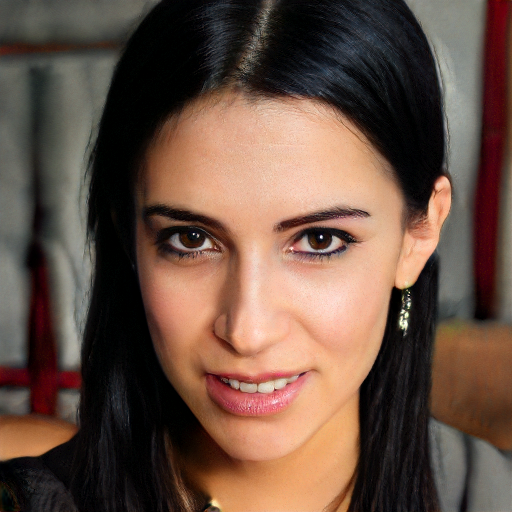

In [14]:
#grid_search on other tags
#search_tags = list(set(modify_tags) - {'gender', 'smile', 'age'})
#display(len(search_tags))
#search_tags[:5]

#img_name = '1574379609.4849255'
#img_name = '1574379629.6737056'
img_name = '1574379432.7478595'

with open(f'data/ffhq-image-seed-{img_name}.pickle', 'rb') as f:
    dlatents_mod_2, display_psi_2 = pickle.load(f)
    print(f'loading image {img_name}')

display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod_2, truncation_psi = display_psi_2), 'RGB').resize((512, 512)))

In [22]:
finetuned_dlatents, losses = tune_with_discriminator(dlatents_mod_2, iterations=1001, learning_rate=0.0005, show_progress=True, opt_class=tf.train.AdadeltaOptimizer)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
#optimizer = tf.train.AdadeltaOptimizer(learning_rate = learning_rate)

FailedPreconditionError: Attempting to use uninitialized value learnable_dlatents/Adadelta_4
	 [[node Adadelta_2/update_learnable_dlatents/ApplyAdadelta (defined at <ipython-input-20-a274333c6447>:74) ]]

Caused by op 'Adadelta_2/update_learnable_dlatents/ApplyAdadelta', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-d7ed2b64856f>", line 1, in <module>
    finetuned_dlatents, losses = tune_with_discriminator(dlatents_mod_2, iterations=1001, learning_rate=0.0005, show_progress=True, opt_class=tf.train.AdadeltaOptimizer)
  File "<ipython-input-20-a274333c6447>", line 74, in tune_with_discriminator
    min_op = optimizer.minimize(discriminator_loss, var_list=[[dlatent_variable]])
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 413, in minimize
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 612, in apply_gradients
    update_ops.append(processor.update_op(self, grad))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 119, in update_op
    update_op = optimizer._apply_dense(g, self._v)  # pylint: disable=protected-access
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\adadelta.py", line 92, in _apply_dense
    use_locking=self._use_locking)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\gen_training_ops.py", line 136, in apply_adadelta
    use_locking=use_locking, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value learnable_dlatents/Adadelta_4
	 [[node Adadelta_2/update_learnable_dlatents/ApplyAdadelta (defined at <ipython-input-20-a274333c6447>:74) ]]


In [23]:
loss_s = pd.Series(losses)
loss_s.plot(figsize=(12, 6))
loss_s.rolling(20).mean().plot(figsize=(12, 6))
#loss_s_sgd = loss_s
#loss_s_sgd_lr_2e_4 = loss_s

NameError: name 'losses' is not defined

In [ ]:
print('before')
display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod_2, truncation_psi = display_psi_2), 'RGB').resize((512, 512)))
print('after')
display(PIL.Image.fromarray(generate_images_from_dlatents(finetuned_dlatents, truncation_psi = display_psi_2), 'RGB').resize((512, 512)))


In [ ]:
a = np.array(list(product(*([[-0.01, 0.01]] * 512))))
a.shape

In [ ]:
sess = tf.get_default_session()
sess.run(tf.assign(dlatent_variable, dlatents_mod_2))

In [ ]:
dlatent_variable.shape

In [ ]:
dlatents_mod_2.shape

### some math for reverse engineering interactive values to obtain latent representation

In [ ]:
(mod_latents_open - mod_latents_closed).min() # todo: make something like grid search around a latent point, rated by discriminator

In [ ]:
(dlatents_gen_open - dlatents_gen_closed).min()

In [ ]:
# todo: probably examine sometimes later, this has great potential
tag_directions['open_mouth']

In [ ]:
# copied code, but modified so I'm not changing any global state
dlatents_mod_2, display_psi_2 = get_latents()

for tag in real_tag_widgets:
    tag_value = round((np.dot(dlatents_mod_2.flatten(), tag_directions[tag].flatten()) / tag_len[tag]) - real_tag_widgets[tag].value, 2)
    print(tag + " | " + str(real_tag_widgets[tag].value) + " | " + str(tag_value))

display(PIL.Image.fromarray(generate_images_from_dlatents(dlatents_mod_2, truncation_psi = display_psi_2), 'RGB'))
# todo, now I replicated that, so would be good if I had method to save those 2 points between which I will be interpolating
# prolly 3 points, the version with ellipsis, but deterministic? or just line from one to another?
# try both, ig
with open('ffhq-image-seed-'+str(time.time())+'.pickle', 'wb') as f:
#with open('celeba-image-seed-'+str(time.time())+'.pickle', 'wb') as f:
    pickle.dump((dlatents_mod_2, display_psi_2), f)

In [ ]:
def calc_current_dlatents(vals_dict):
    if truncate_pre.value == True:
        dlatents_mod_2 = truncate(copy.deepcopy(dlatents_gen), psi_slider.value)
    else:
        dlatents_mod_2 = copy.deepcopy(dlatents_gen)
        
    for tag in real_tag_widgets:
        if tag in vals_dict:
            dlatents_mod_2 += tag_directions[tag] * vals_dict[tag]
        else:
            dlatents_mod_2 += tag_directions[tag] * real_tag_widgets[tag].value
    
    display_psi_2 = None
    if truncate_post.value == True:
        display_psi_2 = psi_slider.value
    return dlatents_mod_2, display_psi_2


In [ ]:
real_tag_widgets[tag].value

In [ ]:
calc_current_dlatents({'open_mouth': -2})

In [ ]:
calc_current_dlatents({'open_mouth': 2})

In [ ]:
# todo: use interpolation scripts to do interpolation between those 2

In [5]:
tf.global_variables()

[<tf.Variable 'G_synthesis/lod:0' shape=() dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise1:0' shape=(1, 1, 4, 4) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise3:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise5:0' shape=(1, 1, 16, 16) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise6:0' shape=(1, 1, 32, 32) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise7:0' shape=(1, 1, 32, 32) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise8:0' shape=(1, 1, 64, 64) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise9:0' shape=(1, 1, 64, 64) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise10:0' shape=(1, 1, 128, 128) dtype=float32_ref>,
 <tf.Variable 'G_synthesis/noise11:0' shape=(1, 1, 128, 128) dtype=float32_ref>,
 <t